# Displaying grids with interpies

*Joseph Barraud*

This notebook introduces the various possibilities of grid display with `interpies`. The function `show` combines several functions of `matplotlib` so that relatively complex maps can be created with only one line of code.

---
### How to display an uneven data distribution?
The range of values of geophysical data, typically from gravity and magnetic surveys, is often dominated by extreme and localised anomalies. Displaying this sort of data can be a challenge. For example, using a linear scale would achieve a true representation of the data content; and large highs and lows would be clearly visible. However, smaller anomalies would also certainly disappear in a large extent of uniform colour.

Two of the most common ways to solve this problem are **hillshading**, and **data normalisation**. Hillshading works with derivatives so will naturally remove large trends and highlight small gradients. Normalisation modifies the data to rebalance the distribution of anomalies: the simplest way to do that is to clip highs and lows to reduce the range of values. There are more sophisticated ways to normalise the data, for example using a logarithmic scale. See [the matplotlib documentation](http://matplotlib.org/gallery/userdemo/colormap_normalizations.html#sphx-glr-gallery-userdemo-colormap-normalizations-py) for more information.

### Colormapping
The way data values are turned into colours is called **colormapping**. As explained in the matplotlib documentation, this involves two steps: (1) the data is normalised to the 0-1 interval, (2) the 0-1 interval is mapped to a sequence of colours (the "colormap"). In this approach, normalisation happens in the first step, and the second step is purely a linear match between two sequences.

In `interpies`, I have experimented a different approach: instead of modifying the data, the colormap is modified to visually achieve the same result as in the first approach. The two steps of colormapping remain linear but the colormap has changed, for example to rebalance an uneven data distribution. 

*The advantage is that the colorbar works as a visual indicator of the amount of normalisation that has been applied to the data.*

Let's look at a few examples of how this works in practice.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
import interpies

##  Display a grid with default settings


The example data come from an aeromagnetic survey collected for the USGS over the town of Blanca in Colorado (Bankey and Grauch, 2004). The survey lines, the gridded data and the report are available from [this page](https://pubs.usgs.gov/of/2004/1229/B/).

The grid can be loaded with the function `open`.

In [3]:
inFile = '../data/brtpgrd.gxf'
grid1 = interpies.open(inFile)

Once loaded in `interpies` as a Grid object, gridded data can be displayed with the `show()` method. 

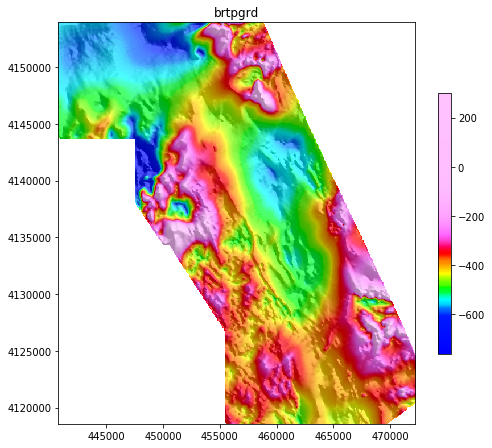

In [4]:
ax = grid1.show()

The default parameters are the ones from the `imshow_hs` function in the `graphics` module.

```
imshow_hs(source, ax=None, cmap='geosoft', cmap_norm='equalize', hs=True,
          zf=10, azdeg=45, altdeg=45, dx=1, dy=1, hs_contrast=1.5, cmap_brightness=1.0,
          blend_mode='alpha', alpha=0.7, contours=False, colorbar=True,
          cb_contours=False, cb_ticks='linear', std_range=1, figsize=(8, 8),
          title=None, **kwargs)
```

The default normalisation is *equalisation*. It can have quite a pronounced effect on the result but it is generally well suited for grids with an uneven data distribution. After all, that is what the [algorithm of histogram equalisation](https://en.wikipedia.org/wiki/Histogram_equalization) is about: redistributing values to obtain a flat histogram, therefore maximising the contrast.

## Use a linear scale
To understand the impact of equalisation, let's revert to a linear scale, i.e. no normalisation:

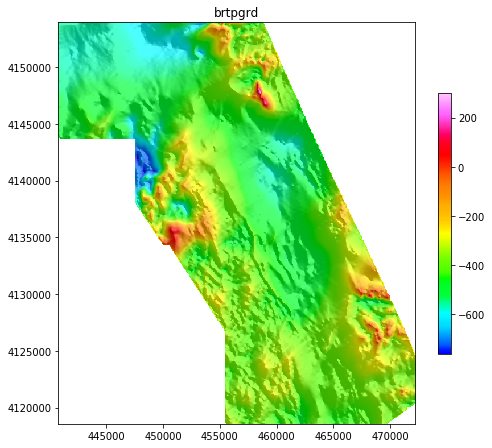

In [5]:
ax = grid1.show(cmap_norm='none')

Notice how the colorbar has changed between the two plots. The second one is the way it would normally look like with the `pyplot.imshow()` function. In the previous plot, the colorbar clearly indicates that a large part of the data range is represented by only one colour, so it's an honest way to remind the reader that the colours have been "manipulated" somehow to highlight some of the smaller anomalies.

## Remove the hillshading
Now, removing the hillshade demonstrates how useful it is to emphasize small variations in the middle of the range:

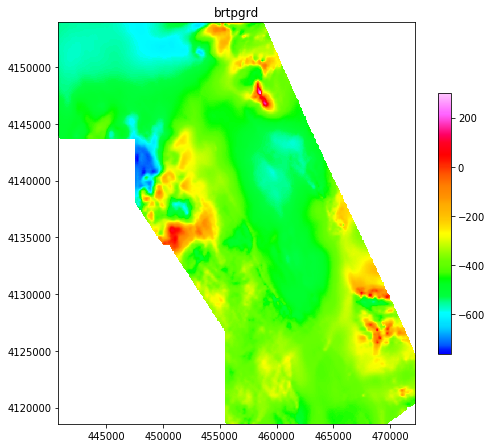

In [6]:
ax = grid1.show(cmap_norm='none', hs=False)

## Change the colormap

...keeping everything else to default values.

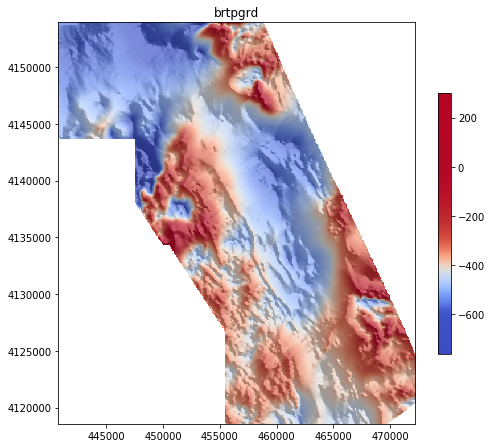

In [7]:
ax = grid1.show(cmap='coolwarm')

Here is `parula`, the MATLAB default.

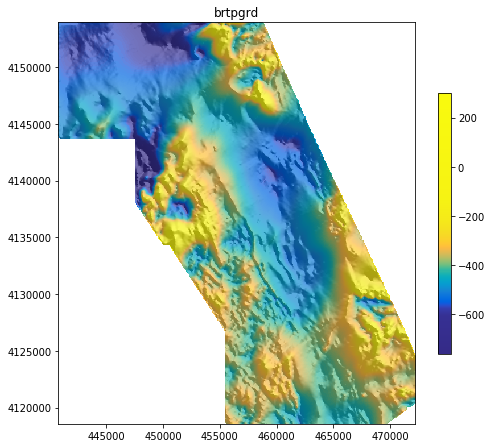

In [8]:
ax = grid1.show(cmap='parula')

Let's try `viridis`, the matplotlib default. Let's also remove the normalisation.

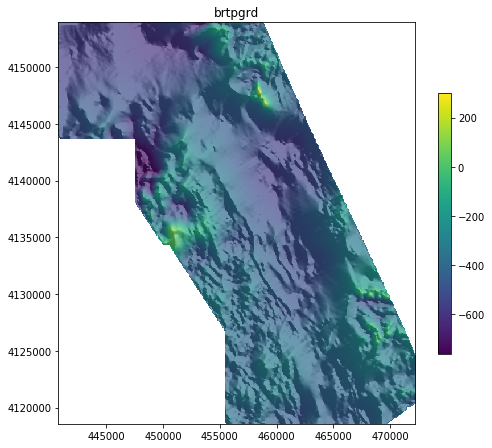

In [9]:
ax = grid1.show(cmap='viridis', cmap_norm='none')

I have also included the `cet_rainbow`, which a rainbow colormap designed by [Peter Kovesi](http://peterkovesi.com/projects/colourmaps/index.html). This particular version is actually called `rainbow_bgyr_35_85_c73` and was downloaded from the [colorcet project](https://github.com/bokeh/colorcet).

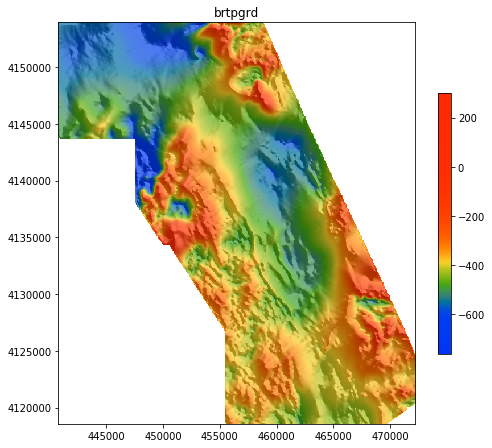

In [10]:
ax = grid1.show(cmap='cet_rainbow')

## Use the "autolevels" normalisation

*Autolevels* normalisation works by clipping the data *intelligently*. The upper and lower boundaries are calculated as percentiles (by default the 98th and 2nd ones, respectively) so they should be well adapted to the input values. Thinking of the distribution of the data in an histogram, this normalisation effectively *clips* the tails of the typical bell-shaped curve that characterises most datasets. As a result, the histogram is stretched, improving the contrast of the image.

As before with equalisation, the autolevels are calculated from the data but applied to the colormap. So the colorbar on the side still shows the full range of values and makes it clear that a lot of values are represented with the same colour.

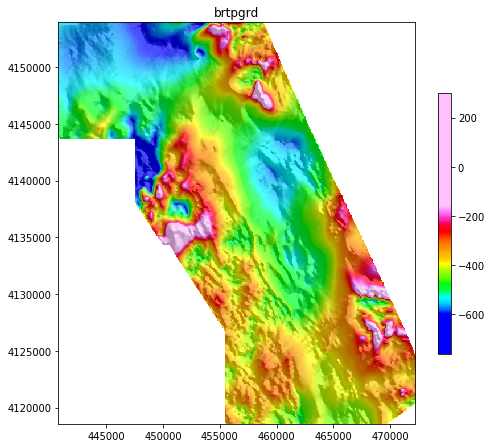

In [11]:
ax = grid1.show(cmap_norm='auto')

Let's try tighter clipping boundaries by changing the percentiles.

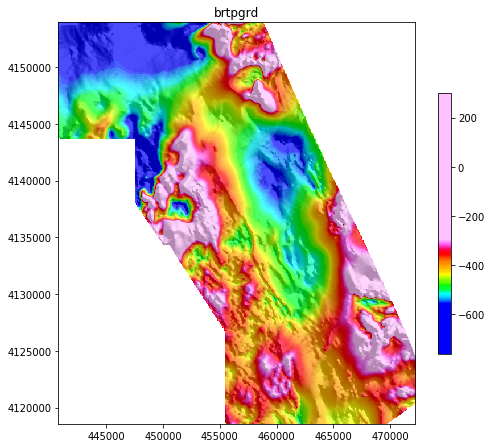

In [12]:
ax = grid1.show(cmap_norm='auto', min_percent=10, max_percent=90)

Here is the same with a *spectral* colormap and no hillshading. Weird looking but effective at isolating extremes.

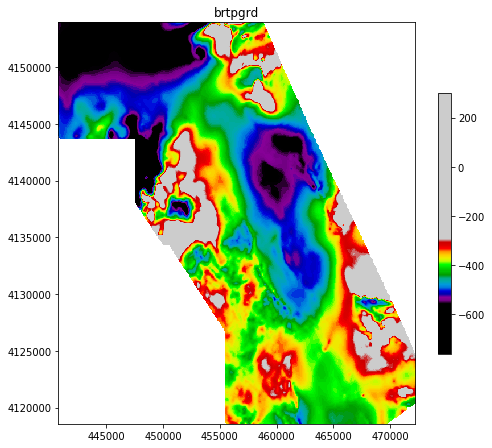

In [13]:
ax = grid1.show(hs=False, cmap='nipy_spectral', cmap_norm='autolevels', min_percent=10, max_percent=90)

## Manual clipping

Clipping the range of values in the traditional way is of course possible. However, notice how the colorbar is also clipped, which hides the real minimum and maximum values.

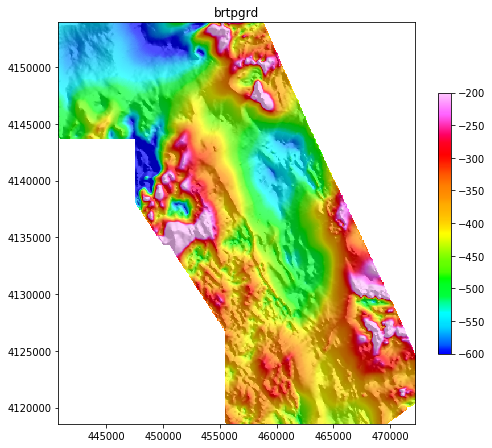

In [14]:
ax = grid1.show(cmap_norm='none', vmin=-600, vmax=-200)

## Make a discrete colormap

All the different types of normalisation from `matplotlib` are also available in `interpies`, including `BoundaryNorm`. This allows you to create a colormap composed of discrete colours. 

Here is an example using boundaries that are equally spaced from the mean. The `graphics.stats_boundaries` function provides directly the necessary list of values with an interval equal to a multiple of the standard deviation. The function also adds the minimum and maximum values to the list.

So here is an example in which a four-colour colormap is created: the central value is the mean (-418), then on both sides there are two intervals equal to the standard deviation, and finally two colours at each end to represent values up to the maximum and minimum of the range.

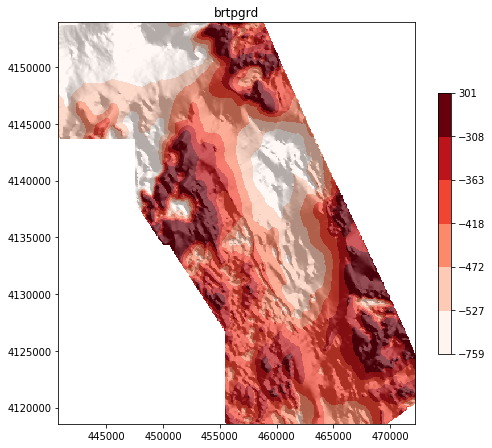

In [15]:
import matplotlib.colors as mcolors
from interpies import graphics
bounds = graphics.stats_boundaries(grid1.data, std_range=1, step=0.5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
ax = grid1.show(cmap='Reds', cmap_norm='none', norm=norm)

Despite the appearance of the colorbar, only the four intervals around the mean are equal, the two extreme ones are much bigger.

One can also increase the number of intervals and decrease the size of each interval. In the following cell, the `cb_ticks` parameter is a trick to ensure meaningful statistics are displayed on the colorbar.

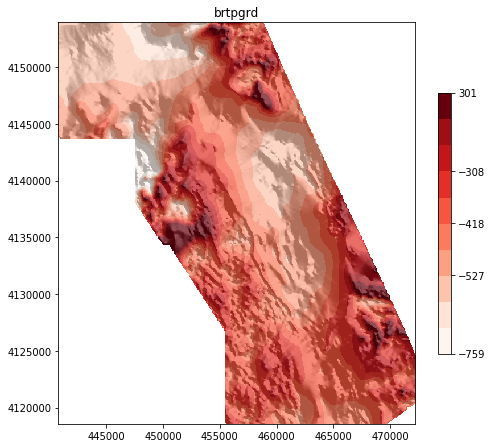

In [16]:
bounds = graphics.stats_boundaries(grid1.data, std_range=2, step=0.5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
ax = grid1.show(cmap='Reds', cmap_norm='none', norm=norm, cb_ticks='stats')

## Display statistics on the colorbar

The same `cb_ticks` parameter can be used for any other normalisation.

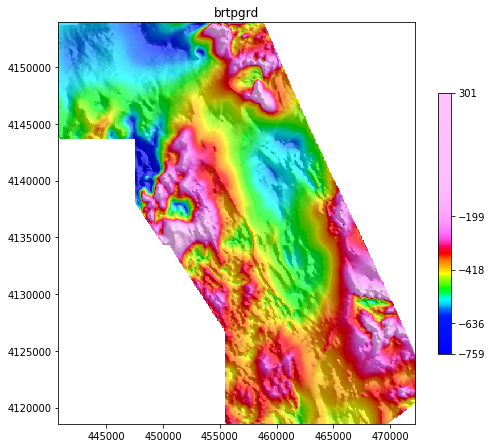

In [17]:
ax = grid1.show(cmap_norm='equalize', cb_ticks='stats', std_range=2)

## Increase or decrease the brightness of the colormap

Sometimes the combination of hillshading and the choice of a dark colormap (at least at one end) can produced an overly dark effect that makes it difficult to distinguish details in the shadows.

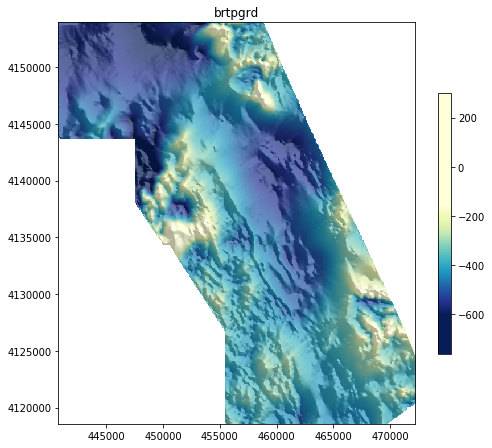

In [18]:
ax = grid1.show(cmap='YlGnBu_r', cmap_norm='autolevels')

The `cmap_brightness` parameter aims at correcting that effect by increasing the brightness of the colormap. A value greater than 1.0 will increase the brightness, while a value smaller than 1.0 will decrease it.

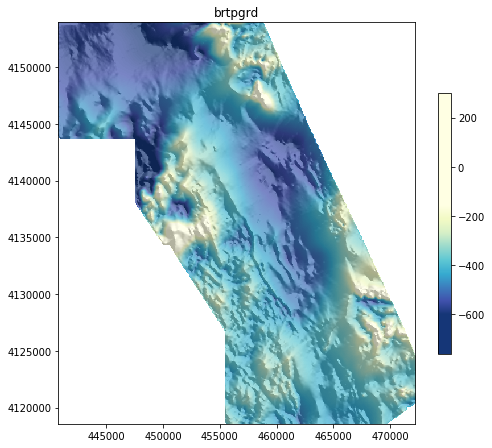

In [19]:
ax = grid1.show(cmap='YlGnBu_r', cmap_norm='autolevels', cmap_brightness=1.5)

Here is a darker version.

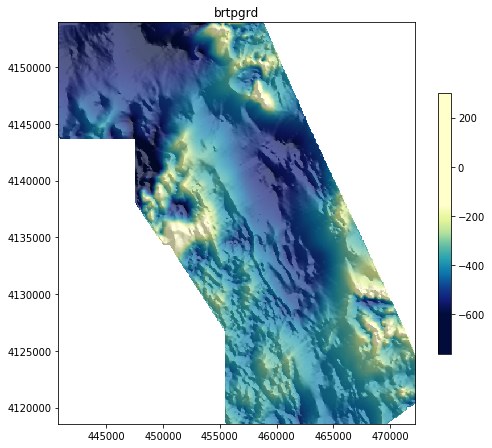

In [20]:
ax = grid1.show(cmap='YlGnBu_r', cmap_norm='autolevels', cmap_brightness=0.75)

## Display the hillshade only

This can be achieved easily by reducing the transparency of the coloured overlay to 0.0. The `alpha` parameter controls the transparency.

Note that colorbar is not displayed if the `alpha` value is set to zero.

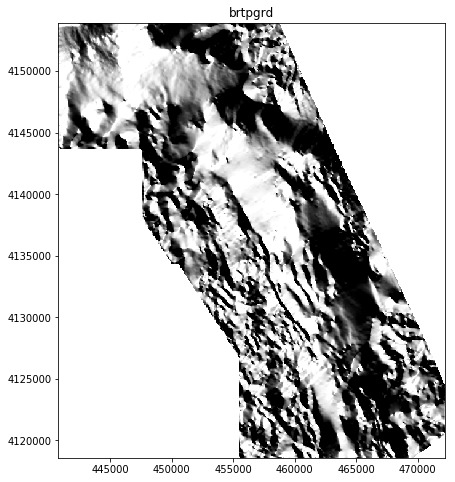

In [21]:
ax = grid1.show(alpha=0.0)

## Increase or decrease the contrast of the hillshade

This is controlled by the `hs_contrast` parameter. The default value is 1.5.

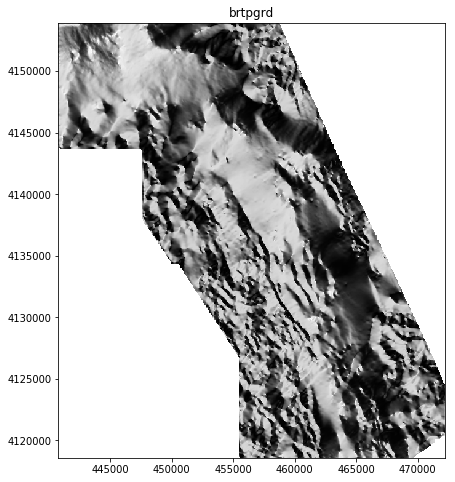

In [22]:
ax = grid1.show(alpha=0.0, hs_contrast=0.5)

Here is an example with high contrast.

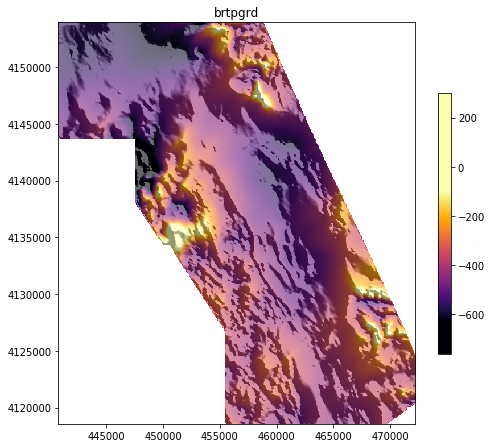

In [23]:
ax = grid1.show(cmap='inferno', cmap_norm='autolevels', min_percent=1, max_percent=99,
                cmap_brightness=1.2, hs_contrast=3.0, alpha=0.6)

## Increase or decrease the vertical exaggeration of the hillshade

Hillshading has been designed originally for terrain data. So when visualising gravity and magnetic data, the Z unit is artificially assumed to be metres, as if it is topography. Therefore, appropriate scaling of Z values is generally necessary to obtain a satisfying shading. The result also depends on the cell size.

The `zf` parameter (or Z factor) controls the vertical exaggeration. The default value is 10.

Here is the version with a smaller vertical exaggeration.

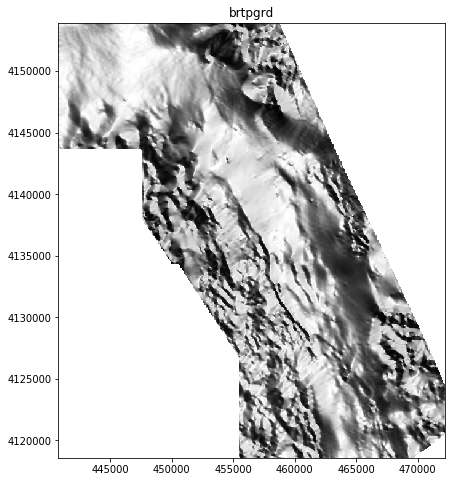

In [24]:
ax = grid1.show(alpha=0.0, zf=1, hs_contrast=1)

This is what happens when `zf` increases.

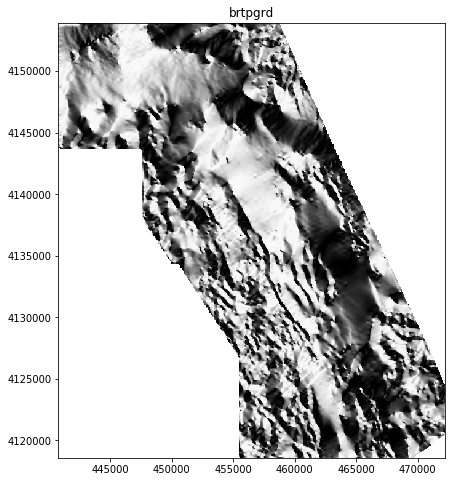

In [25]:
ax = grid1.show(alpha=0.0, zf=1000, hs_contrast=1)

## Display contours

Adding contours is easy, simply use the `contours` argument. If True, the default number of levels (32) are drawn. If fewer or more levels are required, enter the number instead of True.

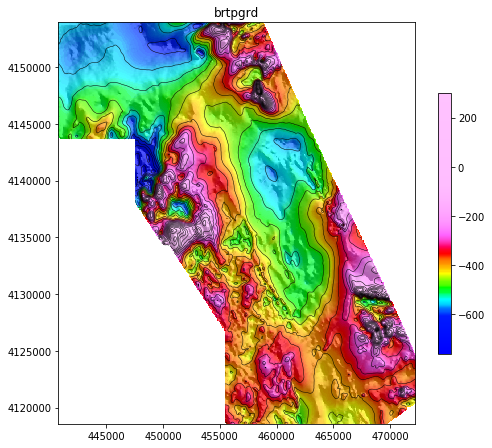

In [26]:
ax = grid1.show(contours=True)

The contours levels can also be shown on the colorbar with the `cb_contours` boolean. This example shows how the contour levels are equally spaced starting at zero.

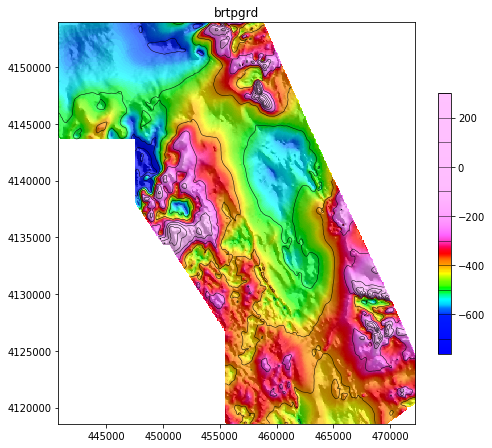

In [27]:
ax = grid1.show(contours=12, cb_contours=True)

There is also an argument (`ct_colors`) to change the colour of the contours. Here I am making them slightly transparent using a RGBA tuple.

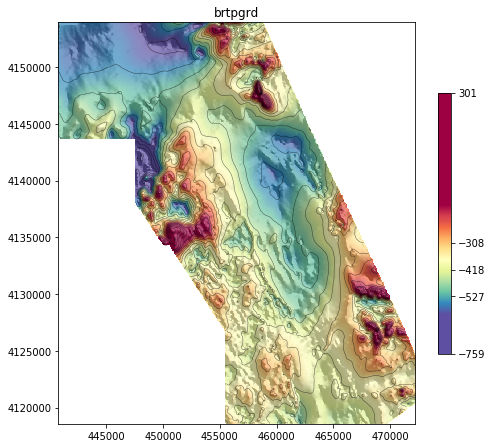

In [28]:
ax = grid1.show(cmap='Spectral_r', cmap_norm='auto', cb_ticks='stats', contours=24, ct_colors=[(0, 0, 0, 0.6)])

The keyword `ct_cmap` controls the colormap of the contours, to be used together with `ct_colors=None`. 

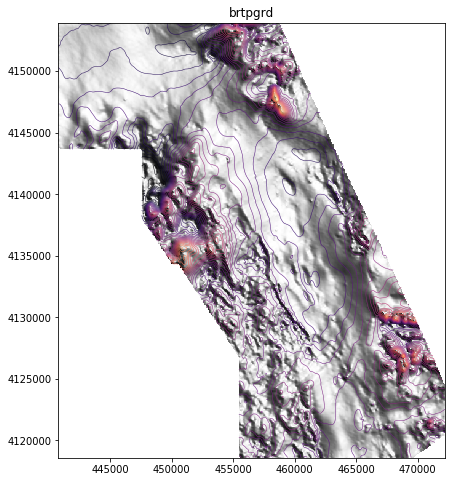

In [29]:
ax = grid1.show(alpha=0.0, zf=0.5, hs_contrast=0.1, contours=True, ct_colors=None, ct_cmap='magma')

A final example with white contours and no hillshade.

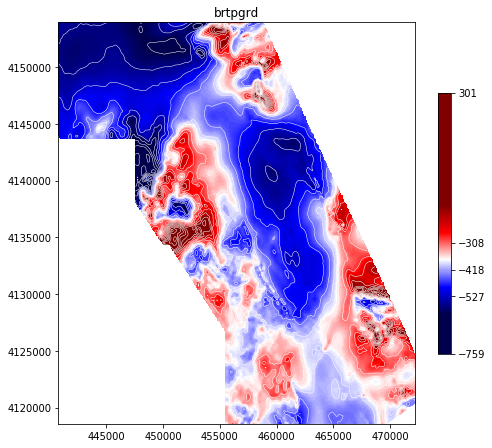

In [30]:
ax = grid1.show(hs=False, cmap='seismic', cmap_norm='auto', contours=32, ct_colors='w', cb_ticks='stats')

## Reference
Bankey, V., Grauch, V.J.S., 2004. Digital aeromagnetic data and derivative products from a helicopter survey over the town of Blanca and surrounding areas, Alamosa and Costilla counties, Colorado, Open-File Report.